<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><ul class="toc-item"><li><span><a href="#Install.-and-imports" data-toc-modified-id="Install.-and-imports-0.1">Install. and imports</a></span></li><li><span><a href="#Util.-plot-functions" data-toc-modified-id="Util.-plot-functions-0.2">Util. plot functions</a></span></li></ul></li><li><span><a href="#Graph" data-toc-modified-id="Graph-1">Graph</a></span></li><li><span><a href="#Geographical-evolution-of-an-epidemics-with-SIR-model" data-toc-modified-id="Geographical-evolution-of-an-epidemics-with-SIR-model-2">Geographical evolution of an epidemics with SIR model</a></span><ul class="toc-item"><li><span><a href="#Outbreaks-in-different-cities" data-toc-modified-id="Outbreaks-in-different-cities-2.1">Outbreaks in different cities</a></span><ul class="toc-item"><li><span><a href="#London,-UK---a-large-city-in-a-densely-populated-region" data-toc-modified-id="London,-UK---a-large-city-in-a-densely-populated-region-2.1.1">London, UK - a large city in a densely populated region</a></span></li><li><span><a href="#Lyon,-France---a-medium-airport" data-toc-modified-id="Lyon,-France---a-medium-airport-2.1.2">Lyon, France - a medium airport</a></span></li><li><span><a href="#Harare,-Zimbabwe---a-small-airport-in-a-low-density-region" data-toc-modified-id="Harare,-Zimbabwe---a-small-airport-in-a-low-density-region-2.1.3">Harare, Zimbabwe - a small airport in a low density region</a></span></li></ul></li><li><span><a href="#Conclusions" data-toc-modified-id="Conclusions-2.2">Conclusions</a></span></li></ul></li></ul></div>

## Install. and imports


Please install the following packages if not already installed:

In [1]:
!pip install ndlib
!pip install mlpleaflet
!pip install imageio

  ERROR: Could not find a version that satisfies the requirement mlpleaflet (from versions: none)
ERROR: No matching distribution found for mlpleaflet


In [13]:
# Inline figures
%matplotlib inline 
# Imports
import networkx as nx
import matplotlib.pyplot as plt
import numpy as np
import pprint #pretty print(dicts)
import warnings
warnings.filterwarnings('ignore') #supressing warnings
import calysto
import pandas as pd
import powerlaw 
import copy

## Util. plot functions

Some useful functions for SIR/SIS models:

In [14]:
def plt_directed(G, title):
    '''
    This function allows the visualization of the directed graph given as input in a nice way.
    ARGS :
        - G : nx graph object which is the graph that we want to plot.
        - title : string corresponding to the title of the plot.
    RETURN :
        - None object is return but a plot is printed as output.
    '''
    plt.figure(figsize=(15,10))
    pos = nx.layout.spring_layout(G) # set a layout
    node_sizes = [3 + i/50 for i in range(len(G))] # set different size for each node
    M = G.number_of_edges()
    edge_colors = range(2, M + 2) # set different color for each edge
    nodes = nx.draw_networkx_nodes(G, pos, node_size=node_sizes, node_color='blue')
    edges = nx.draw_networkx_edges(G, pos, node_size=node_sizes,
                                   arrowsize=1, edge_color=edge_colors,
                                   edge_cmap=plt.cm.Blues, width=0.3)

    ax = plt.gca()
    ax.set_axis_off()
    plt.title(title)
    plt.show()
    
def InitializeSIRModel(InitialInfected, Network, beta=0.01, gamma=0.01): #note that InitialInfected is a list of node ids
    sir_model = sir.SIRModel(Network) #create the ndlib model object
    
    #initialize the parameters
    sir_cfg = mc.Configuration()
    sir_cfg.add_model_parameter('beta', beta)
    sir_cfg.add_model_parameter('gamma', gamma)
    
    sir_cfg.add_model_initial_configuration('Infected', InitialInfected) #infect the nodes at which the infection starts

    sir_model.set_initial_status(sir_cfg)

    return sir_model#, sir_iter, trends

def average_over_simulation(model, n_nodes, n_iterations = 100, n_simulations = 10): #n_nodes has to be the number of nodes in the network
    'Return probability of each node to be susceptible/infected/removed at each iteration.'
    
    # create empty arrays for probabilities
    prob_susceptible = np.ndarray(shape=(n_iterations, n_nodes))
    #prob_infected = np.ndarray(shape=(n_iterations, n_nodes))
    prob_infected_tot = np.zeros(shape=(n_iterations, n_nodes))
    prob_removed = np.ndarray(shape=(n_nodes, n_iterations))

    
    for i in range(n_simulations):  
        print('Simulation {}...'.format(i))
        prob_infected = np.zeros(shape=(n_iterations, n_nodes))

        #Simulate:
        for j in range(n_iterations):
            #Iterate and get status
            sir_model.iteration()
            current_status = sir_model.status 
            copy_status = copy.deepcopy(current_status)
            
            # assign status 0 to removed status
            for key, value in copy_status.items():
                if value == 2:
                    copy_status[key] = 0 
            if (2 in copy_status.values()): print('Problem')
            prob_infected[j] = np.array(list(copy_status.values()))

        model.reset()  
        
        #update:
        prob_infected_tot = np.add(prob_infected_tot, prob_infected)
    
    prob_infected_tot = np.divide(prob_infected_tot, n_simulations) 
    return prob_infected_tot 

In [15]:
def time_infected(iterations):
    '''
    Given a simulation, return a dictionary with the number of steps
    since each node was infected.
    '''
    res = {i: 0 for i in iterations[0]['status'].keys()}
    
    current_status = {}
    
    for it in iterations:
        current_status.update(it['status'])
        for k, v in current_status.items():
            if v != 0:
                res[k] += 1
    
    return res

def pair_elements(*args):
    '''
    Put elements together to make it easier to plot.
    '''
    output = []
    for node_id in args[0].keys():
        output.append(tuple(i[node_id] for i in args))
    return np.array(output)

# Graph

Let us load the graph:

In [16]:
#Specific imports
from load_data import load_data, weighted_network_creation
from utils import plt_directed

# Add external information
# Airport_Network = load_data()
Airport_Network = weighted_network_creation()

# Print out the summary information of the graphs
print('Airport_Network Informations Summary: \n')
print(nx.info(Airport_Network))

Airport_Network Informations Summary: 

Name: 
Type: DiGraph
Number of nodes: 3334
Number of edges: 37505
Average in degree:  11.2493
Average out degree:  11.2493


With each node, we have the following information provided:

In [17]:
list(Airport_Network.nodes(data=True))[0]

('1',
 {'City': 'Goroka',
  'Country': 'Papua New Guinea',
  'Latitude': -6.0816898345900015,
  'Longitude': 145.391998291})

In [18]:
n_nodes = Airport_Network.number_of_nodes() #we'll need the number of nodes

In [19]:
coord = pair_elements(nx.get_node_attributes(Airport_Network, "Latitude"),
        nx.get_node_attributes(Airport_Network, "Longitude"))

# Geographical evolution of an epidemics with SIR model

**Note: to push on git we had to display only a subset of images, forming snapshots of the GIF animation that was produced.**

In [1]:
import ndlib.models.ModelConfig as mc
import ndlib.models.epidemics.SIRModel as sir
from ndlib.viz.mpl.DiffusionTrend import DiffusionTrend 

The goal here is to gain insights into how an infection would spread on the world if it were to start in a given city and use the network of air routes to spread. The assumptions here are that an infection would first outbreak within a city and, still within this city, would spread. Therefore, when we say that the outbreak starts in a city, we will use all nodes corresponding to all airports "belonging" to the city. This is motivated by the fact that people from a city may use different airports, depending on destinations or airlines, for example. Also, it emphasizes the importance of the city in the way the spread evolve as the number of airports in a city reflects the size of city. 
We aim to see how the size of a city and its airports, using the degree of the nodes (number of air routes per airports) would affect the geographical spread of an epidemics around the world.

According to [this page](https://wanderwisdom.com/transportation/Top-5-Largest-Airports-in-the-World), one of the biggest airports in the world in 2017 is: 
-  **London Heathrow Airport, UK (LHR, 7th)**

when considering the total number of passengers that depart of arrive from the airport. "Largest" airports could be determined using other metrics, such as fret traffic or size of the infrastructures, yet the current metric is suitable when considering the spread of a disease transmitted through people. 

In addition, let us choose some airports of medium size, such :
- **Lyon Airport, France (LYS)**

And now a rather small airport, which we may also consider as somewhat isolated:
-  **Harare Airport, Zimbabwe (HRE)**

In [2]:
from collections import defaultdict

selected_cities = ['London','Lyon', 'Harare']
all_nodes = nx.get_node_attributes(Airport_Network,'City')
city_nodes = defaultdict(list)

for node_idx, city_name in all_nodes.items():
    if city_name in selected_cities:
        city_nodes[city_name].append(node_idx)
city_nodes

NameError: name 'nx' is not defined

Degrees of these nodes:

In [22]:
for node in city_nodes.values():
    for n in node:
        print('Node {} has degree {}.'.format(n, Airport_Network.degree(node)[n]))

Node 174 has degree 10.
Node 507 has degree 342.
Node 492 has degree 170.
Node 502 has degree 330.
Node 548 has degree 305.
Node 503 has degree 71.
Node 1005 has degree 25.
Node 1335 has degree 155.


The combined degrees of each node for a given city motivate us in selection the cities of London, Lyon and Harare as three cities of decreasing "importance" and size. Also, these three cities are all big cities, or "metropoles". London is the capital of the UK and one of the biggest city in the world and the biggest city in Europe. London is a "world" city. Lyon is the second biggest urban area of France, in a densely populated region, itself in the densely populated Europe yet still of a smaller scale than London. Finally, Harare is the capital of Zimbabwe, a sparsely populated country in a sparsely populated continent yet remains a city of more than 1 million inhabitants. 

Therefore, such cities are plausible candidates in the scenario that some new kind of disease or virus would appear suddenly in a city which has the potential to effectively engender a pandemics. Naturally, it could have been interesting to also pick a very small, local airport, or aerodrome, yet this would not suit the scenario of a worldwide geographical spread as well, as an outbreak in such a small town would perhaps die off within the city.

## Outbreaks in different cities

Parameters $\beta$ and $\gamma$ were set to values optimized for the Assignment 4 as they represent a good equilibrium between two possibilities: the pandemics may take off relatively quickly but in some cases after a few iterations it is also possible that the infection dies off.

In [23]:
#Model parameters
beta = 0.01
gamma = 0.01 
n_iter = 500
print('Cities of interest are:', city_nodes.keys())


Cities of interest are: dict_keys(['London', 'Harare', 'Lyon'])


Here, we simulate an outbreak 5 times for the same city, over 150 iterations. At each iteration, a node infect a neighbouring node with probability $\beta=0.01$ while an infected node recovers with probability $\gamma=0.01$. Since there is a stochastic component in this simulation, it is necessary to simulate several times in order to obtain **the probability of infection for a given node at a given iteration** in the expected simulation, that is, what we would expect on average. The results below present the probability of infection without conditions. In other words, once a node has been removed and therefore cannot be infected again, its probability will reduce over time. This is such that one should not perceive that all nodes may be infected increasingly more throughout the 500 iterations but rather put the emphasis on the nodes that are currently infected. Although in the SIR model and the library used the "recovered" state is definitive, this allows us to envision the fact that recovered nodes may possibly be infected in the future. This is similar than the SIS model which we did not simulate. The motivation behind this is account for possible rebounce of the epidemics, which is a scenario naturally observed. In fact, diffusion network models tend to be more and more SIS rather than SIR as in large networks a phenomenon may never die but only move around.

### London, UK - a large city in a densely populated region

In [24]:
#Get nodes i.e. all airports of the city
nodes = city_nodes['London']
nodes

['174', '507', '492', '502', '548', '503']

#### Plot with probabilites

In [ ]:
n_iter = 150
n_sim = 5

#Init. model and average
sir_model = InitializeSIRModel(nodes, Airport_Network, beta = beta, gamma = gamma)
sir_model.get_status_map()
prob_london = average_over_simulation(sir_model, n_nodes, n_iterations = n_iter, n_simulations = n_sim)
sir_model.reset()

Making sure that this is indeed probabilities (max. possible value is 1.0):

In [52]:
print(np.max(prob_london))

1.0


In [29]:
from matplotlib import cm
from matplotlib.colors import ListedColormap, LinearSegmentedColormap, Normalize

prob_color = cm.get_cmap('summer')
norm = plt.Normalize()

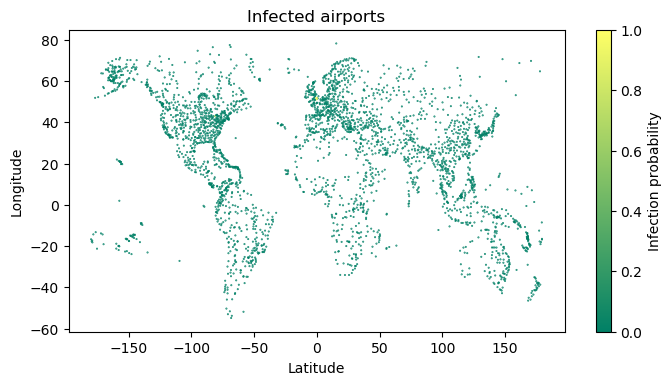

In [17]:
#Plot probability at onset:
fig, ax = plt.subplots(figsize = (8, 4), dpi=100)
scatter = plt.scatter(coord[:, 1], coord[:, 0], s=0.8, c = prob_color(norm(prob_london[0])), alpha = 1.0, marker = '.')
sm = cm.ScalarMappable(cmap=prob_color, norm=norm)
sm.set_array([])
bar = plt.colorbar(sm)
bar.set_label('Infection probability')
plt.xlabel('Latitude', fontsize = 10)
plt.ylabel('Longitude', fontsize = 10)
title = 'Infected airports'
plt.title(title, fontsize=12)
plt.show()

At onset, we only the infected nodes are yellow (probability of infection is 1.0, i.e. infected here).

Now, let's  do this for each iteration to see the evolution of infection probabilities for each node through the simulations (average), using some functions to plot the density map and create a time animation of all simulations:

In [5]:
import os, sys
import datetime
import imageio
from pprint import pprint
import time
import datetime
e = sys.exit

duration=0.2

def plot_density_map(prob, iteration_number, title = 'Infected airports'):
    fig, ax = plt.subplots(figsize = (8, 4), dpi=100)
    scatter = plt.scatter(coord[:, 1], coord[:, 0], s=0.8, c = prob_color(norm(prob[iteration_number])), alpha = 1.0, marker = '.')
    sm = cm.ScalarMappable(cmap=prob_color, norm=norm)
    sm.set_array([])
    bar = plt.colorbar(sm)
    bar.set_label('Infection probability')
    plt.xlabel('Latitude', fontsize = 10)
    plt.ylabel('Longitude', fontsize = 10)
    title = 'Infected airports at iteration {}'.format(iteration_number)
    plt.title(title, fontsize=12)
    #plt.show()
    return fig
    
def create_gif(filenames, duration):
    ''' 
    A function that creates a GIF, found at: 
    https://www.quora.com/How-do-I-create-a-GIF-file-from-a-bunch-of-JPEG-files-using-Python
    '''
    images = []
    for filename in filenames:
        images.append(imageio.imread(filename))
    output_file = 'Lon-%s.gif' % datetime.datetime.now().strftime('%Y-%M-%d-%H-%M-%S')
    imageio.mimsave(output_file, images, duration = duration)

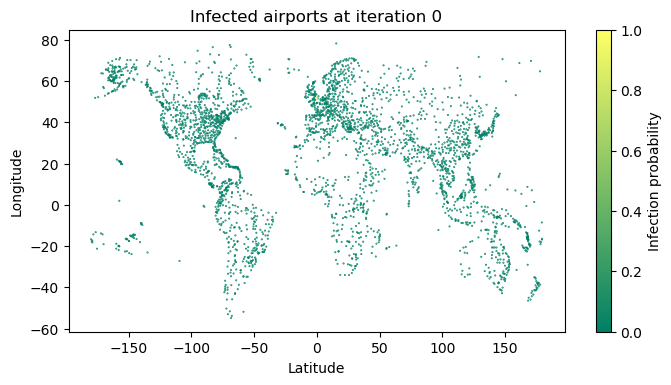

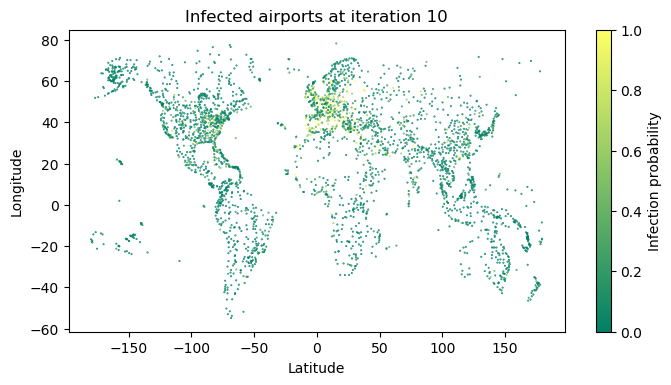

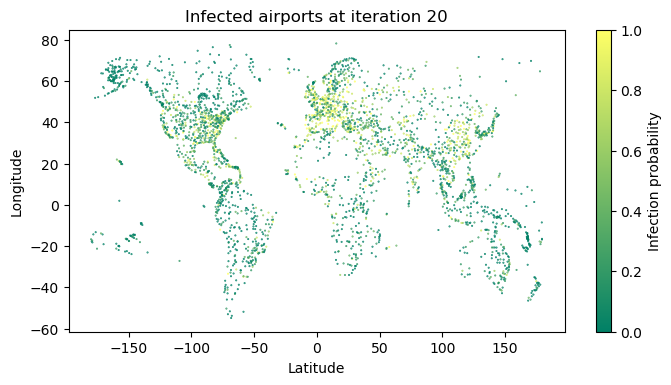

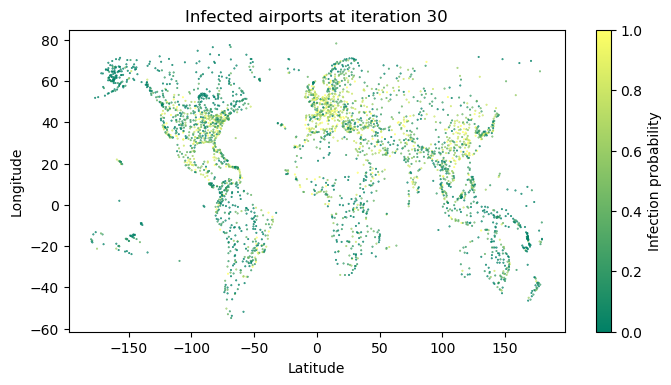

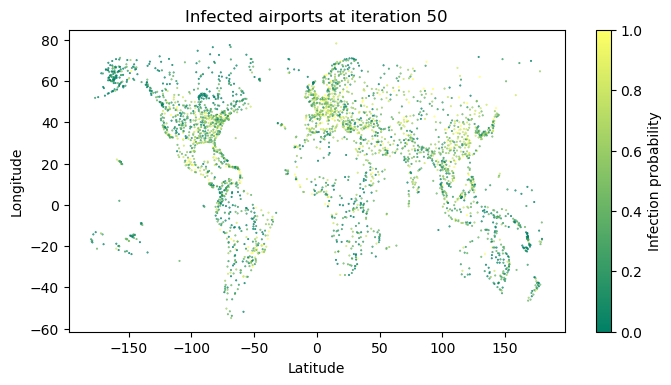

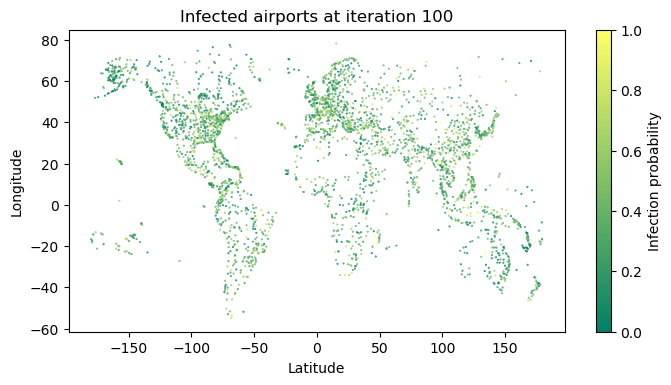

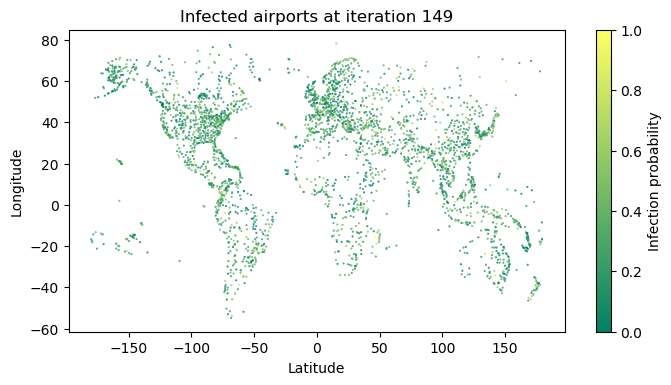

In [57]:
for i in [0, 10, 20, 30, 50, 100, 149]:
    fig = plot_density_map(prob_london, i)
    #save images 
    #fig_title = '{}_lon_map'.format(i)
    #fig.savefig(fig_title+'.png')

In [58]:
#Create gif
#filenames = sorted(filter(os.path.isfile, [x for x in os.listdir() if x.endswith("lon_map.png")]), key=lambda p: os.path.exists(p) and os.stat(p).st_mtime or time.mktime(datetime.now().timetuple()))
#create_gif(filenames, duration)

In [59]:
#from IPython.core.display import HTML
#from IPython.display import display, Image

#print('If infection starts in London, these nodes (airports) will be infected : {}'.format(nodes))
#with open('Lon-2019-52-24-17-52-08.gif','rb') as file:
#    display(Image(file.read()))

 **Analysis**
  - **First**, and quite naturally, the probability of infection increases more rapidly (after a few iterations only) in the most densely populated and most populous areas of the world, such as: 
      - the North-eastern coast of the United States, which correspond to the megalopolis from Washington D.C. to Boston
      - Eastern Asia but more precisely Japan and the Eastern coast of China
      - Western Europe
  - These areas also correspond to regions which have "world" cities in their cores, such as New York City, Shanghai or Tokyo, for example. These cities have major significance in world affairs, in terms of finance, culture, economy, politics, although at different extent. This is quite logical as populous regions are more connected to each other and there are more exchanges thus explaining that an infection would first spread of the major axis of exchange in the world.
  - Also, since these areas are themselves densely populated and contain numerous airports, the epidemics spread first more quickly within these three world megalopolises (D.C.-Baltimor-NYC-Boston / the London-Frankfurt-Milano axis/Japan). 
  
  - **Also**, we observe that the next regions infected correspond to secondary regions of global importance which are characterized by usually one very populous or "important" city, but not as much as the major megalopolises of the world. These areas include:
      - South East Asia (Singapore)
      - South-eastern Brazil (Rio de Janeiro)
      - Western USA (Los Angeles)
      - Mexico City
  - These regions and cities are also world cities in the sense that they have major regional aura and significance, yet less than the famous New York City, London, Tokyo trio.
  - Therefore, it makes sense that they would be infected at a second stage of the worldwide spread of the epidemics.
  - **Then**, we notice that there areas that affected much later, if not affected at all, such as:
      - Alaska, US
      - Northern Europe (Northern Scotland and Northernmost Scandinavia)
      - Melanesia in the Pacific Islands
      - the Northern part of the Andes cordillera
      - central Amazonia and the outback of Australia
  - These areas include countries economically developed with supposedly developed infrastrucures (_e.g_ Alaska or Northern Europe) and countries less so developed such as the countries in Melanesia. However, it seems that all these areas are characterized by a much less dense population, which may explain why they are infected later, or not at all. 
  - Also, we observe that areas such as Northern Norway and the Australian outback resist infection surprinsingly well, as they display very low infection probability while being just next to areas where infection probability are very high (e.g. Brisbane, Australia). In the case of the Australian outback, this could be explained by the fact that these airports are very small and not so used, considering the fact that there are major airports nearby, such as Brisbane / Gold Coast, from which it is possible to drive to the outback instead of catching another plane.
  
  

### Lyon, France - a medium airport

Let's do the same for a smaller city yet in a densely populated area.

In [25]:
#Get nodes i.e. all airports of the city
nodes = city_nodes['Lyon']
nodes

['1335']

Simulation:

In [26]:
n_iter = 150
n_sim = 5

#Init. model and average
sir_model = InitializeSIRModel(nodes, Airport_Network, beta = beta, gamma = gamma)
sir_model.get_status_map()
prob_lyon = average_over_simulation(sir_model, n_nodes, n_iterations = n_iter, n_simulations = n_sim)
sir_model.reset()

Simulation 0...
Simulation 1...
Simulation 2...
Simulation 3...
Simulation 4...


We redefine the function to make the GIF:

In [27]:
def create_gif(filenames, duration):
    ''' 
    A function that creates a GIF, found at: 
    https://www.quora.com/How-do-I-create-a-GIF-file-from-a-bunch-of-JPEG-files-using-Python
    '''
    images = []
    for filename in filenames:
        images.append(imageio.imread(filename))
    output_file = 'Lyon-%s.gif' % datetime.datetime.now().strftime('%Y-%M-%d-%H-%M-%S')
    imageio.mimsave(output_file, images, duration = duration)

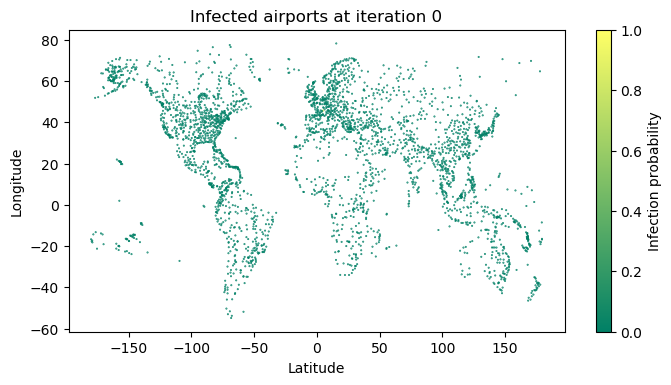

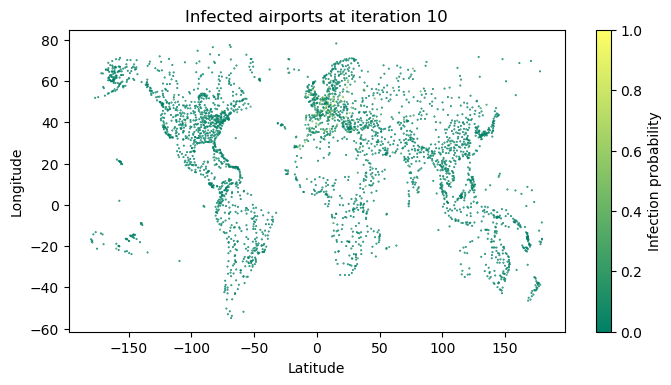

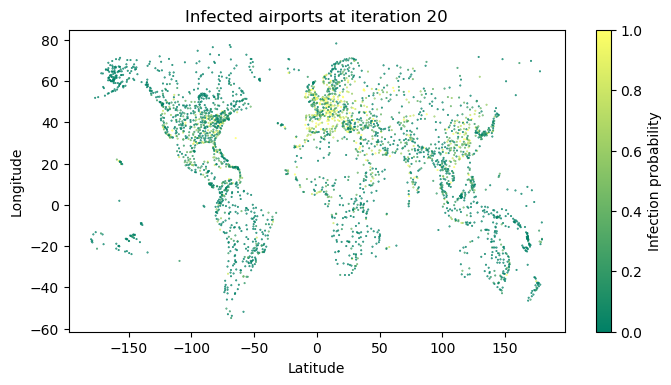

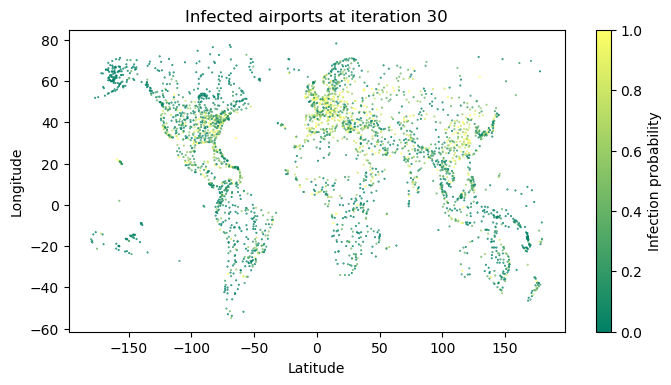

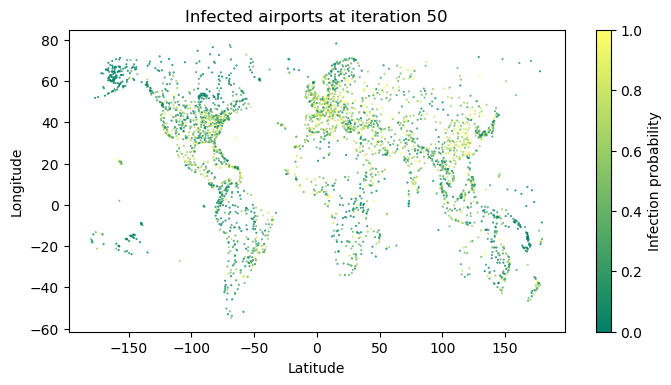

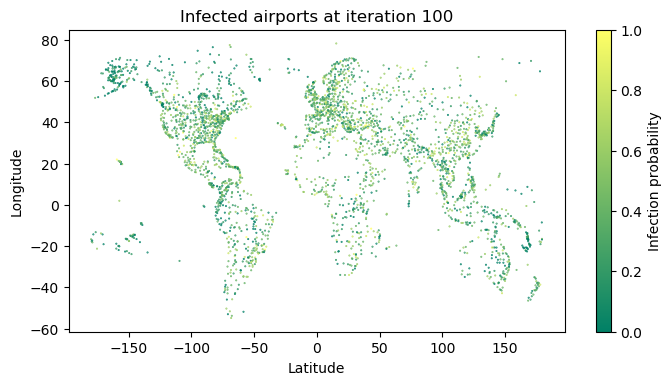

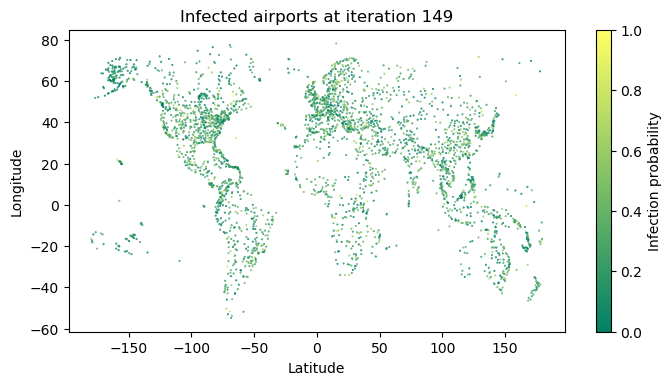

In [30]:
for i in [0, 10, 20, 30, 50, 100, 149]:
    fig = plot_density_map(prob_lyon, i)
    #save images 
    #fig_title = '{}_lyon_map'.format(i)
    #fig.savefig(fig_title+'.png')

In [37]:
#Create gif
#filenames = sorted(filter(os.path.isfile, [x for x in os.listdir() if x.endswith("lyon_map.png")]), key=lambda p: os.path.exists(p) and os.stat(p).st_mtime or time.mktime(datetime.now().timetuple()))
#create_gif(filenames, duration)

Now, let's see the how it spreads over time on average:


In [27]:
#print('If infection starts in Lyon, these nodes (airports) will be infected : {}'.format(nodes))
#with open('Lyon-2019-40-24-18-40-42.gif','rb') as file:
#    display(Image(file.read()))

If infection starts in Lyon, these nodes (airports) will be infected : ['1335']


**Analysis**
- The first observation is the fact that the same regions exhibit higher infection probabilities yet a lower pace. Indeed, comparing iteration 15 between when the outbreak starts in London versus when it starts in Lyon shows that the three areas of Western Europe, Eastern USA and Estearn China/Japan have lower infection probabilities for a lot more airports.
- Also, the order at which specific regions start to show higher infection probabilities is very similar between the two simulations. In particular, it is the onset at which global infection is visible that differs most.
- Similarly, peripheral areas indicate the same tendency as before: they are infected on average much later than the rest. 
- Thus, with a city such as Lyon, with an airport of regional importance in a region that is densely populated and with a lot of infrastructures, we observe some notable differences such as the onset of the pandemics.

### Harare, Zimbabwe - a small airport in a low density region

Now, let us repeat the process again with a small airport in a region of low population density:

In [31]:
#Get nodes i.e. all airports of the city
nodes = city_nodes['Harare']
nodes

['1005']

In [32]:
n_iter = 150
n_sim = 5

#Init. model and average
sir_model = InitializeSIRModel(nodes, Airport_Network, beta = beta, gamma = gamma)
sir_model.get_status_map()
prob_har = average_over_simulation(sir_model, n_nodes, n_iterations = n_iter, n_simulations = n_sim)
sir_model.reset()

Simulation 0...
Simulation 1...
Simulation 2...
Simulation 3...
Simulation 4...


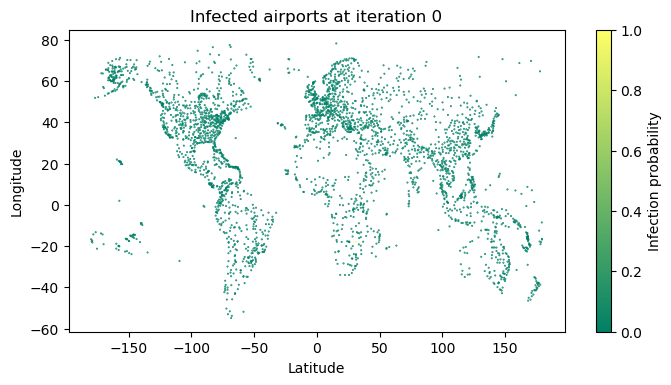

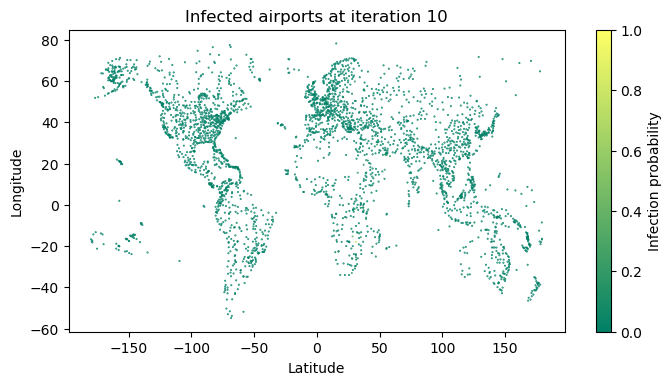

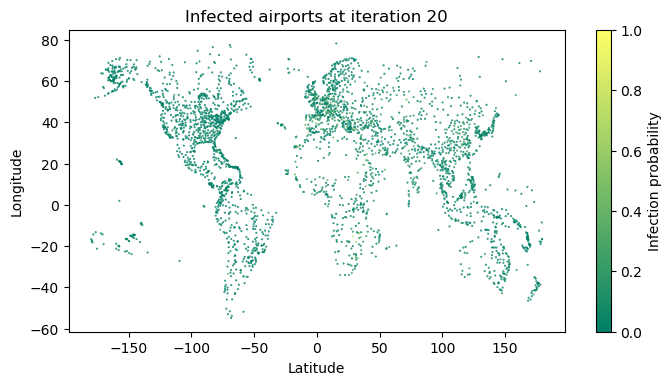

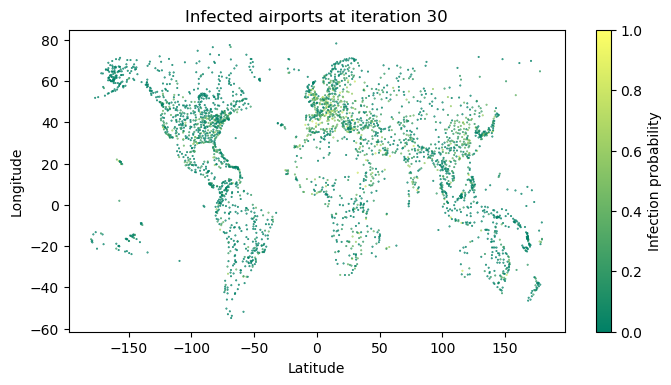

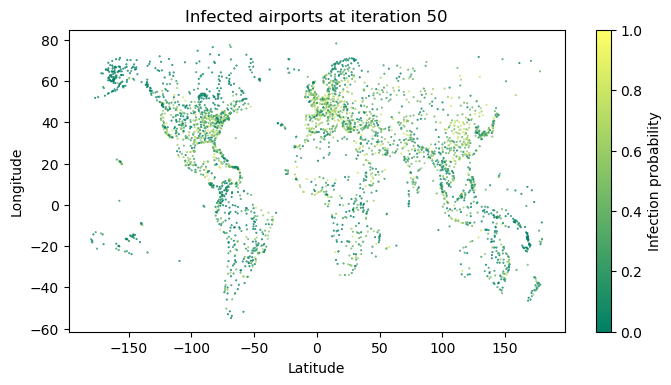

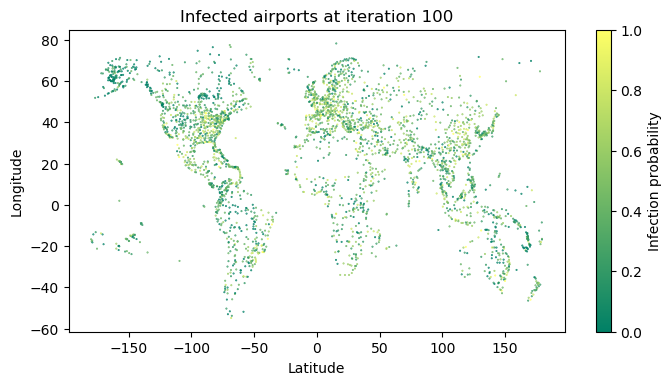

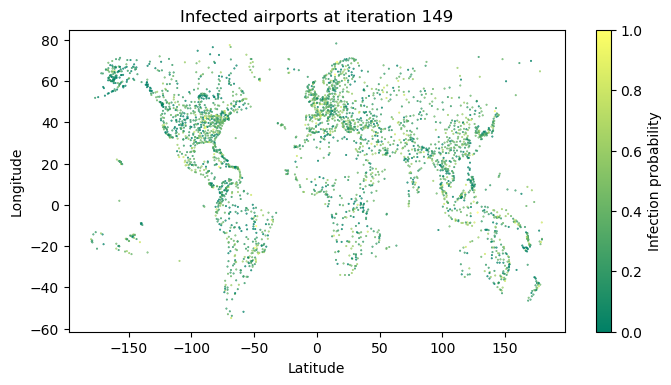

In [34]:
for i in [0, 10, 20, 30, 50, 100, 149]:
    fig = plot_density_map(prob_har, i)
    #save images 
    #fig_title = '{}_lyon_map'.format(i)
    #fig.savefig(fig_title+'.png')

We redefine the function to make the GIF:

In [35]:
def create_gif(filenames, duration):
    ''' 
    A function that creates a GIF, found at: 
    https://www.quora.com/How-do-I-create-a-GIF-file-from-a-bunch-of-JPEG-files-using-Python
    '''
    images = []
    for filename in filenames:
        images.append(imageio.imread(filename))
    output_file = 'Har-%s.gif' % datetime.datetime.now().strftime('%Y-%M-%d-%H-%M-%S')
    imageio.mimsave(output_file, images, duration = duration)

#filenames = sorted(filter(os.path.isfile, [x for x in os.listdir() if x.endswith("har_map.png")]), key=lambda p: os.path.exists(p) and os.stat(p).st_mtime or time.mktime(datetime.now().timetuple()))
#create_gif(filenames, duration)

Now, as a GIF:

In [36]:
#print('If infection starts in Harare, these nodes (airports) will be infected : {}'.format(nodes))
#with open('Har-2019-01-24-19-01-17.gif','rb') as file:
#    display(Image(file.read()))

**Analysis**:
- We observe the same pattern in terms of the order of which large areas will start to be more likely infected.
- Again, as the airport is smaller (as shown assumed by its degree), it connects to less airports and, additionally, has a longer distance to major hubs, such as London for example. As a result, the moment where more nodes starts to be visibly more likely to be infected occur much higher.
- The moment where the pandemics is at its peak occurs however roughly around the same iteration 60.
- Another notable difference is the fact the continent of Africa is a lot more likely to be infected compared to the situations where London and Lyon are the sources of infections. This is expected as Harare is located in Africa and is likely to be more connected to neighboring countries.

## Conclusions 

In consequence, the modelisation of a pandemic starting in three different cities of various importance in terms of their role in the flight global network has allowed us to confirm expected characteristics of the world in terms of density of population and thus density of airports, but also in terms of fluxes of people around the globe. 
We  observe that the size of the city or, even, the sizes of the airports which belong to a city, 
do not matter much in how far, in terms of geographical spread, the pandemic will go. However, we do notice that the main difference is the fact that the more important the city is, the sooner the epidemic will go from being very regional and contained to an epidemic of a global scale, that is, a pandemic. 